In [0]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
tf.__version__

'2.1.0-rc1'

In [0]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Creating the dataset of word problems

*Please add the correct path to load the data file*

In [0]:
with open('data_final.pkl', 'rb') as f:
  df = pickle.load(f)

In [0]:
df.shape

(38144, 2)

In [0]:
df.head()

,Question,Equation
963,A painter needed to paint 12 rooms in a build...,X=(7.0*(12.0-5.0))
3897,Brenda had 253 raspberry. John gripped some ra...,X = 253 - 66
27626,Casey wants to share some Bread among 17 frien...,X = 39 * 17
32530,Liza had 34 Press. Thomas furnished him some m...,X = 64 - 34
16266,George wants to distribute 125 mangos among 25...,X = 125 / 25


In [0]:
def convert_eqn(eqn):
  '''
  Add a space between every character in the equation string.
  Eg: 'x = 23 + 88' becomes 'x =  2 3 + 8 8'
  '''
  elements = list(eqn)
  return ' '.join(elements)

In [0]:
input_exps = list(df['Question'].values)

In [0]:
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)

In [0]:
# Input: Word Problem
input_exps[:5]

[' A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest? ',
 'Brenda had 253 raspberry. John gripped some raspberry. Now Brenda has 66  raspberry. How many did John grippeds?',
 'Casey wants to share some Bread among 17 friends.If each friend get 39 Bread, then how many Bread john would have?',
 'Liza had 34 Press. Thomas furnished him some more. Now Liza has 64 Press. How many did Thomas furnish him?',
 'George wants to distribute 125 mangos among 25 friends. How many would each friend acquire?']

In [0]:
# Target: Equation
target_exps[:5]

['X = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'X   =   2 5 3   -   6 6',
 'X   =   3 9   *   1 7',
 'X   =   6 4   -   3 4',
 'X   =   1 2 5   /   2 5']

In [0]:
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())

(38144, 38144)

In [0]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(38144, 23603)

### Preprocessing and Tokenizing the Input and Target exps

In [0]:
def preprocess_input(sentence):
  '''
  For the word problem, convert everything to lowercase, add spaces around all
  punctuations and digits, and remove any extra spaces. 
  '''
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return '<start> ' + sentence + ' <end>'

In [0]:
def preprocess_target(sentence):
  '''
  For the equation, convert it to lowercase and remove extra spaces
  '''
  sentence = sentence.lower().strip()
  return '<start> ' + sentence + ' <end>'

In [0]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [0]:
preprocessed_input_exps[:5]

['<start> a painter needed to paint 1 2 rooms in a building . each room takes 7 hours to paint . if he already painted 5 rooms , how much longer will he take to paint the rest ? <end>',
 '<start> brenda had 2 5 3 raspberry . john gripped some raspberry . now brenda has 6 6 raspberry . how many did john grippeds ? <end>',
 '<start> casey wants to share some bread among 1 7 friends . if each friend get 3 9 bread , then how many bread john would have ? <end>',
 '<start> liza had 3 4 press . thomas furnished him some more . now liza has 6 4 press . how many did thomas furnish him ? <end>',
 '<start> george wants to distribute 1 2 5 mangos among 2 5 friends . how many would each friend acquire ? <end>']

In [0]:
preprocessed_target_exps[:5]

['<start> x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) ) <end>',
 '<start> x   =   2 5 3   -   6 6 <end>',
 '<start> x   =   3 9   *   1 7 <end>',
 '<start> x   =   6 4   -   3 4 <end>',
 '<start> x   =   1 2 5   /   2 5 <end>']

In [0]:
def tokenize(lang):
  '''
  Tokenize the given list of strings and return the tokenized output
  along with the fitted tokenizer.
  '''
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [0]:
len(inp_lang_tokenizer.word_index)

5889

In [0]:
input_tensor

array([[   3,  106, 2456, ...,    0,    0,    0],
       [   3,  282,    8, ...,    0,    0,    0],
       [   3,  813,   45, ...,    0,    0,    0],
       ...,
       [   3,  382,   14, ...,    0,    0,    0],
       [   3,  169,    8, ...,    0,    0,    0],
       [   3,  406,    8, ...,    0,    0,    0]], dtype=int32)

In [0]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [0]:
len(targ_lang_tokenizer.word_index)

47

In [0]:
target_tensor

array([[2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       ...,
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0],
       [2, 4, 1, ..., 0, 0, 0]], dtype=int32)

### Create a tf.data dataset

In [0]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                target_tensor,
                                                                                                test_size=0.05,
                                                                                                random_state=42)

In [0]:
len(input_tensor_train)

36236

In [0]:
len(input_tensor_val)

1908

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 32
units = 256
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1
dropout = 0.5
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
vocab_inp_size, vocab_tar_size

(5890, 48)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 124]), TensorShape([64, 66]))

### Encoder Decoder Model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    # Bidirectional GRU Unit
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout))

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state1, state2 = self.gru(x, initial_state = hidden)
    state = [state1,state2]
    return output, state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)),tf.zeros((self.batch_sz, self.enc_units))]

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # Get attention_weights
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(100)

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    #LSTM Unit
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, cell_state = self.lstm(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoints

In [0]:
# !rm -r /gdrive/My\ Drive/ADL\ Project/checkpoints/training_checkpoints/aashna_bidir_new

In [0]:
checkpoint_dir = os.path.join(drive_root, "ADL Project/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "training_checkpoints/aashna_bidir_new")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Checkpoints directory is /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/aashna_bidir_new
Creating a checkpoints directory


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [0]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
else:
  epoch_num = 0

In [0]:
epoch_num

0

### Training

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    # print(enc_output.shape)
    # print(len(enc_hidden))
    # print(enc_hidden[0].shape)
    dec_hidden = enc_hidden[0]

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input, to ensure proper training
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 5

for epoch in range(epoch_num, EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  checkpoint.save(file_prefix = checkpoint_prefix)
  print('Saved epoch: {} at {}'.format(epoch+1, checkpoint_dir))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5086
Epoch 1 Batch 100 Loss 0.2943
Epoch 1 Batch 200 Loss 0.2160
Epoch 1 Batch 300 Loss 0.2370
Epoch 1 Batch 400 Loss 0.2115
Epoch 1 Batch 500 Loss 0.2505
Saved epoch: 1 at /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/aashna_bidir_new
Epoch 1 Loss 0.2379
Time taken for 1 epoch 390.9043769836426 sec

Epoch 2 Batch 0 Loss 0.1775
Epoch 2 Batch 100 Loss 0.1959
Epoch 2 Batch 200 Loss 0.1591
Epoch 2 Batch 300 Loss 0.1599
Epoch 2 Batch 400 Loss 0.1521
Epoch 2 Batch 500 Loss 0.1344
Saved epoch: 2 at /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/aashna_bidir_new
Epoch 2 Loss 0.1610
Time taken for 1 epoch 326.494660615921 sec

Epoch 3 Batch 0 Loss 0.1497
Epoch 3 Batch 100 Loss 0.1319
Epoch 3 Batch 200 Loss 0.1441
Epoch 3 Batch 300 Loss 0.1420
Epoch 3 Batch 400 Loss 0.1098
Epoch 3 Batch 500 Loss 0.1159
Saved epoch: 3 at /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/aashna_bidir_new
Epoch 3 Loss 0.1293
Time taken for 1 epoch 3

### Evaluation

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input
    sentence = preprocess_input(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def evaluate_accuracy(inputs):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in range(len(inputs.numpy()[0])):
      if inputs.numpy()[0][i] != 0: #padding token
        sentence += inp_lang_tokenizer.index_word[inputs.numpy()[0][i]] + ' '

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    result_seq = ''
    
    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result_seq += str(predicted_id) +' '
        
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result_seq, result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result_seq, result, sentence, attention_plot

In [0]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [0]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 50 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')

  target_sentence = ''
  for i in target_val_batch.numpy()[0]:
    if i!= 0:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  target_sentence = target_sentence.split('<start> ')[1]
  # print('True:{}'.format(target_sentence))
  y_true.append([target_sentence.split(' ')])

  res_seq, res, sent, att = evaluate_accuracy(inp_val_batch)
  y_pred.append(res.split(' '))
  
  if target_sentence == res:
    acc_cnt += 1

50
Accuracy count:  7
------------------
100
Accuracy count:  21
------------------
150
Accuracy count:  36
------------------
200
Accuracy count:  47
------------------
250
Accuracy count:  64
------------------
300
Accuracy count:  81
------------------
350
Accuracy count:  90
------------------
400
Accuracy count:  108
------------------
450
Accuracy count:  121
------------------
500
Accuracy count:  136
------------------
550
Accuracy count:  149
------------------
600
Accuracy count:  165
------------------
650
Accuracy count:  176
------------------
700
Accuracy count:  192
------------------
750
Accuracy count:  209
------------------
800
Accuracy count:  221
------------------
850
Accuracy count:  229
------------------
900
Accuracy count:  242
------------------
950
Accuracy count:  248
------------------
1000
Accuracy count:  259
------------------
1050
Accuracy count:  272
------------------
1100
Accuracy count:  287
------------------
1150
Accuracy count:  301
------------

In [0]:
print('Corpus BLEU score of the model: ', corpus_bleu(y_true, y_pred))

Corpus BLEU score of the model:  0.44778402085810237


In [0]:
print('Accuracy of the model: ', acc_cnt/len(input_tensor_val))

Accuracy of the model:  0.25681341719077566


#### Translation and Attention Plots

In [0]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[0] if i != 0][1:-1])

In [0]:
check_str

'ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ?'

Input: <start> ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ? <end>
Predicted translation: x = 1 9 8 / 1 3 <end> 


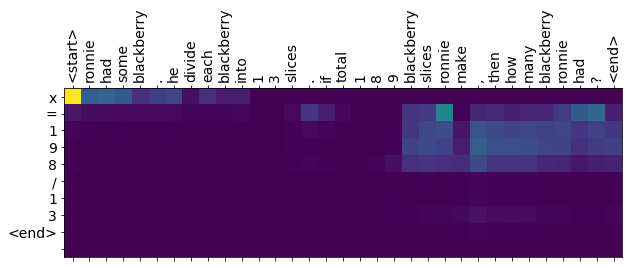

In [0]:
translate(check_str)

Input: <start> jerry had 1 3 5 pens . john took 1 9 from him . how many does jerry have left ? <end>
Predicted translation: x = 1 3 5 - 1 9 <end> 


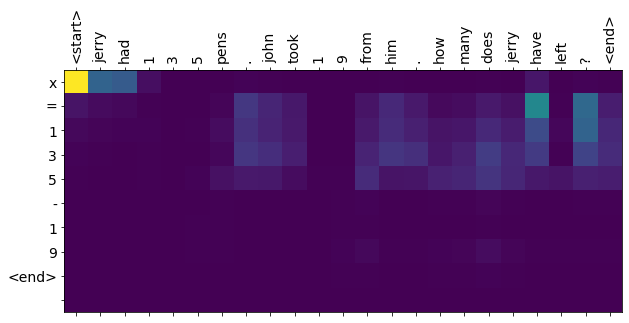

In [0]:
translate("Jerry had 135 pens. John took 19 from him. How many does Jerry have left?")

### Conclusions

This model does not overfit as the baseline did with the old dataset. It gives reasonable scores for the dataset. However, we can see from the attention plots that even though a lot of translations are correct or very close, the word it is supposed to give to attention to while translating is not correct.

This is why we also decided to experiment with Transformer models as well to see if it will give better results.

Sources:
1. https://web.stanford.edu/class/cs224n/reports/custom/15843468.pdf
2. https://www.tensorflow.org/tutorials/text/nmt_with_attention#top_of_page